# Device benchmarks

The purpose of this notebook is to run a couple simple benchmarks to compare single-threaded CPU performance and GPU performance on my test machine. My computer specs are ...

- CPU: Intel 9700K @ 3.3GHz
- GPU: RTX 2080

In this case, hoomd was compiled in single-precision mode, to hopefully aid the performance on the RTX card. The 20-series of GPUs have 32-times the fp32 throughput compared to fp64, and the 30-series expands this to 64-times.

## Imports

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc

In [3]:
from monk import nb
from monk import prep
from monk import pair
import freud

In [4]:
def prepare_system(sim: hoomd.Simulation, N: int, seed: int):

    phi = 1.2
    L = prep.len_from_phi(N, phi, dim=3)
    snap = prep.approx_euclidean_snapshot(N, L, prep.init_rng(seed), dim=3, ratios=[80, 20], diams=[1.0, 0.88])

    sim.create_state_from_snapshot(snap)

    dt = 0.0025
    kT = 1.0

    integrator = hoomd.md.Integrator(dt=dt)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)
    nvt = hoomd.md.methods.NVT(hoomd.filter.All(), kT, 0.25)
    integrator.forces = [lj]
    integrator.methods = [nvt]
    sim.operations.integrator = integrator

    sim.run(0)

    nvt.thermalize_thermostat_dof()

    sim.run(1000)

def device_benchmark(device: hoomd.device.Device, N: int, seed: int = 0):

    sim = hoomd.Simulation(device, seed=seed)

    prepare_system(sim, N, seed)

    start_time = time.time()
    sim.run(400)
    duration = time.time() - start_time

    del sim

    gc.collect()

    return duration

In [5]:
devices = {"cpu": hoomd.device.CPU(), "gpu": hoomd.device.GPU()}
Ns = np.logspace(8, 15, num=8, base=2).astype(int)
Ns

array([  256,   512,  1024,  2048,  4096,  8192, 16384, 32768])

In [6]:
output_data = {}

for d_name, device in devices.items():
    device_data = []
    print(f"device: {d_name}")
    for N in Ns:
        print(f"\tN: {N:<7} duration: ", end="")
        duration = device_benchmark(device, N)
        print(f"{duration:.2f}s")
        device_data.append(duration)
    output_data[d_name] = device_data

device: cpu
	N: 256     duration: 0.10s
	N: 512     duration: 0.23s
	N: 1024    duration: 0.42s
	N: 2048    duration: 0.91s
	N: 4096    duration: 1.88s
	N: 8192    duration: 3.75s
	N: 16384   duration: 7.67s
	N: 32768   duration: 15.74s
device: gpu
	N: 256     duration: 0.03s
	N: 512     duration: 0.04s
	N: 1024    duration: 0.04s
	N: 2048    duration: 0.04s
	N: 4096    duration: 0.05s
	N: 8192    duration: 0.06s
	N: 16384   duration: 0.08s
	N: 32768   duration: 0.11s


In [7]:
extended_Ns = np.logspace(16, 20, num=8, base=2).astype(int)
extended_Ns


array([  65536,   97386,  144715,  215045,  319557,  474860,  705639,
       1048576])

In [8]:
extended_output_data = {}
extended_device_data = []
print("device: gpu")
for N in extended_Ns:
    print(f"\tN: {N:<7} duration: ", end="")
    duration = device_benchmark(devices["gpu"], N)
    print(f"{duration:.2f}s")
    extended_device_data.append(duration)
extended_output_data["gpu-extended"] = extended_device_data

device: gpu
	N: 65536   duration: 0.19s
	N: 97386   duration: 0.29s
	N: 144715  duration: 0.39s
	N: 215045  duration: 0.56s
	N: 319557  duration: 0.85s
	N: 474860  duration: 1.31s
	N: 705639  duration: 1.90s
	N: 1048576 duration: 2.70s


In [12]:
pickle_name = "device-benchmarks.pickle"
if pickle_name in glob.glob("*"):
    with open(pickle_name, "rb") as f:
        data = pickle.load(f)
        output_data = data["data"]
        extended_output_data = data["extended_data"]

Text(0, 0.5, 'duration (s)')

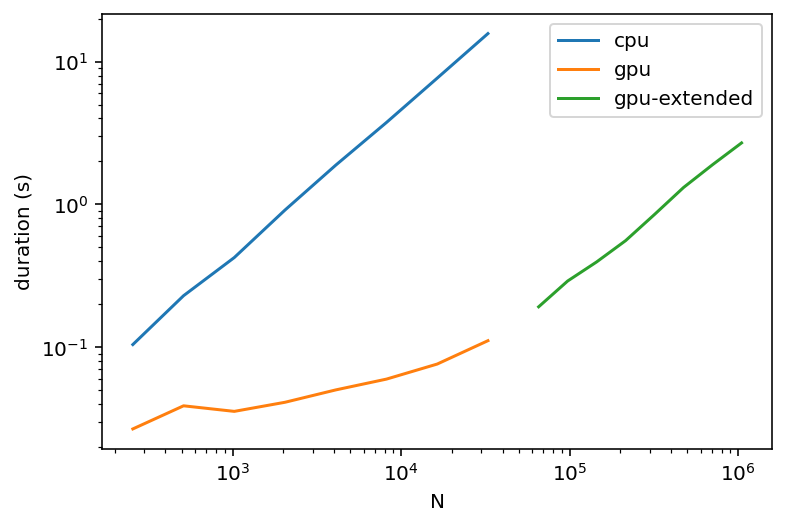

In [13]:
for key, values in output_data.items():
    plt.plot(Ns, values, label=key)
plt.plot(extended_Ns, extended_output_data["gpu-extended"], label="gpu-extended")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("N")
plt.ylabel("duration (s)")

In [10]:

if pickle_name not in glob.glob("*"):
    with open(pickle_name, "wb") as f:
        pickle.dump(
            dict(
                Ns=Ns,
                data=output_data,
                extended_Ns=extended_Ns,
                extended_data=extended_output_data
            ),
            f
        )

# Conclusion

Wow, the speedup from switching to single-precision is massive! In fact, it seems to make more sense to run simulation with N at least ~100,000. 